# Gym crowdness predictor

## Goal

Predict the best time to go to the gym and avoid crowds, so you can enjoy a great workout 

## Libraries

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


## Load data

In [2]:
crw = pd.read_csv('data/gym_crowdness.csv')

## EDA

In [3]:
crw.shape

(62184, 11)

In [4]:
crw.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17


In [5]:
crw.isna().sum()

number_people           0
date                    0
timestamp               0
day_of_week             0
is_weekend              0
is_holiday              0
temperature             0
is_start_of_semester    0
is_during_semester      0
month                   0
hour                    0
dtype: int64

In [8]:
print(crw['date'].min())
print(crw['date'].max())

2015-08-14 17:00:11-07:00
2017-03-18 19:22:51-07:00


In [24]:
crw['date_trucated'].value_counts().describe()

count    540.000000
mean     115.155556
std       28.844119
min        1.000000
25%       99.000000
50%      100.000000
75%      143.000000
max      199.000000
Name: count, dtype: float64

In [25]:
crw.describe()

,number_people,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
count,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000
mean,29.072543,45799.437958,2.982504,0.282870,0.002573,58.557108,0.078831,0.660218,7.439824,12.236460
std,22.689026,24211.275891,1.996825,0.450398,0.050660,6.316396,0.269476,0.473639,3.445069,6.717631
min,0.000000,0.000000,0.000000,0.000000,0.000000,38.140000,0.000000,0.000000,1.000000,0.000000
25%,9.000000,26624.000000,1.000000,0.000000,0.000000,55.000000,0.000000,0.000000,5.000000,7.000000
50%,28.000000,46522.500000,3.000000,0.000000,0.000000,58.340000,0.000000,1.000000,8.000000,12.000000
75%,43.000000,66612.000000,5.000000,1.000000,0.000000,62.280000,0.000000,1.000000,10.000000,18.000000
max,145.000000,86399.000000,6.000000,1.000000,1.000000,87.170000,1.000000,1.000000,12.000000,23.000000


### Observations

- Date is decomposed in other features, day of week, month, hour, timestamp
- There are other variables that bring interesting data like temperature, if is start of semester, if is during semester, if is weekend, if is holiday
- There is no missing data
- The number of people at the gym goes from 0 to 128
- We have data on 540 days
  - Min observations in a day 1
  - Max observations in a day 199
  - Avg observations in a day 115
  - The dataset is not balanced, we need to keep this in mind
- Timestamp starts at 0 at 7am
- On average there are 29 people
- 30% of the data is on weekend
- 0.2% is on weekeend, this column looks like wont be really needed
- 7.8% of the data is at the start of the semester
- 66% is during the semester

## Model building

### Feature engineering

In [20]:
crw['date'] = pd.to_datetime(crw['date'], utc=True) 
crw['date_trucated'] = crw['date'].dt.date

### Feature selection

In [30]:
numerical_feats = crw.select_dtypes(include=['number']).columns
categorical_feats = crw.select_dtypes(include=['object']).columns

print(numerical_feats)
print(categorical_feats)

Index(['number_people', 'timestamp', 'day_of_week', 'is_weekend', 'is_holiday',
       'temperature', 'is_start_of_semester', 'is_during_semester', 'month',
       'hour'],
      dtype='object')
Index(['date_trunc', 'date_trucated'], dtype='object')


In [33]:
abs(crw[numerical_feats].corr()['number_people']).sort_values(ascending=False)

number_people           1.000000
hour                    0.552049
timestamp               0.550218
temperature             0.373327
is_during_semester      0.335350
is_start_of_semester    0.182683
is_weekend              0.173958
day_of_week             0.162062
month                   0.097854
is_holiday              0.048249
Name: number_people, dtype: float64

- The most relevant features linearly correlated with **number_people**
  - hour and timestamp, they both get the same data, we will use only hour
  - temperature
  - is_during_semester
  - is_weekend

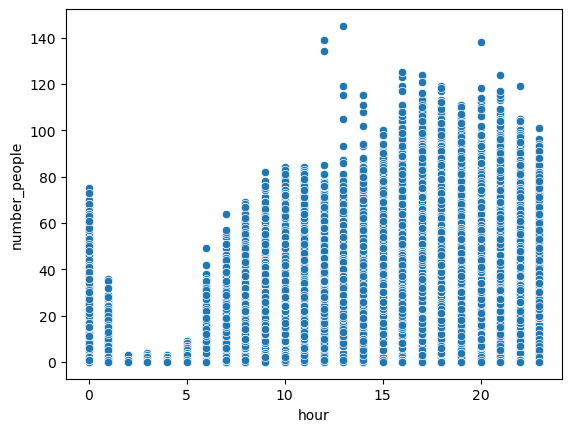

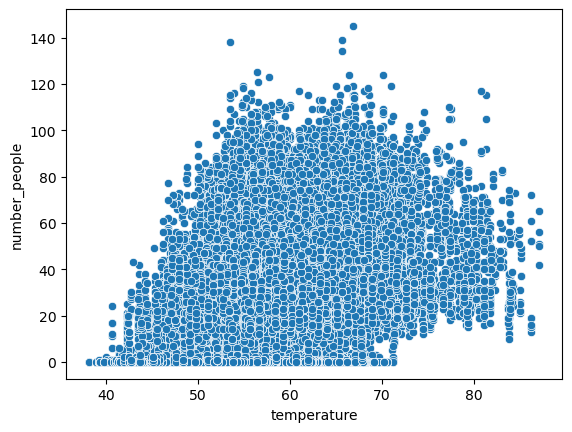

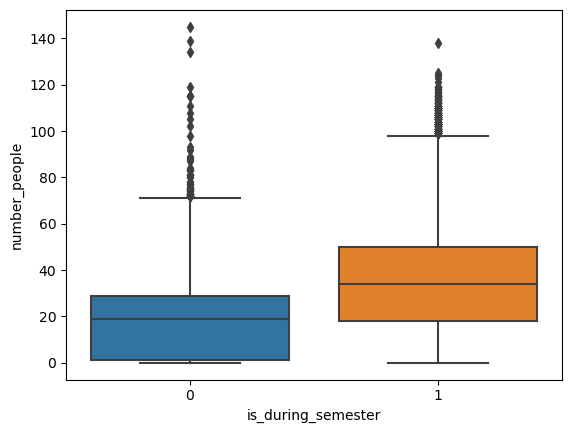

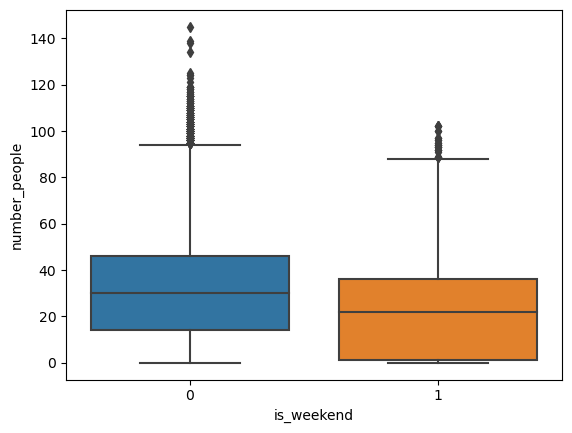

In [40]:
cols = ['hour', 'temperature', 'is_during_semester', 'is_weekend']

for col in cols:
    if col in ['is_during_semester', 'is_weekend']:
        sns.boxplot(x=col, y='number_people', data=crw)
    else:
        sns.scatterplot(x=col, y='number_people', data=crw)
    plt.show()

- The gym looks less crowded form 12pm to around 7 am
- The avg of is_during semester looks relevant